<a href="https://colab.research.google.com/github/GiannaSal/phase-2-project/blob/charity/eda_top_earning_studios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis: Identifying Consistently Top-Earning Movie Genres

**Business question:** Which genre consistently earns the most at the box office?

**Definition of “consistently”:** a genre that ranks at/near the top in *most years* (not just overall), and whose yearly earnings are relatively stable (not dominated by one-off spikes).




## 1. Importing Libraries

In [10]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path

# Settings
pd.set_option("display.max_columns", 200)
sns.set_theme(style="whitegrid")


## 2. Loading the Data

In [11]:


CANDIDATES = [
    Path("box.movie_gross.csv.gz"),
    Path("bom.movie_gross.csv.gz"),
    Path("movies.csv"),            # in case you re-exported/renamed
    Path("movies.csv.gz"),
]

existing = [p for p in CANDIDATES if p.exists()]
if not existing:
    raise FileNotFoundError(
        "Could not find the dataset. Place one of these files in the working directory: "
        + ", ".join(str(p) for p in CANDIDATES)
    )

data_path = existing[0]
print(f"Loading: {data_path}")

# Read file (gzip CSV or normal CSV)
if data_path.suffix == ".gz":
    df = pd.read_csv(data_path, compression="gzip")
else:
    df = pd.read_csv(data_path)

df.head()


Loading: bom.movie_gross.csv.gz


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


## 3. Inspecting the Data

In [3]:
# First few rows
display(df.head())

# Shape
print("Shape:", df.shape)

# Columns and dtypes
display(pd.DataFrame({"column": df.columns, "dtype": df.dtypes.values}))

# Summary stats (numeric)
display(df.describe(include=[np.number]))

# Quick missingness snapshot
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_fraction").head(15))


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


Shape: (3387, 5)


,column,dtype
0,title,object
1,studio,object
2,domestic_gross,float64
3,foreign_gross,object
4,year,int64


,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


,missing_fraction
foreign_gross,0.398583
domestic_gross,0.008267
studio,0.001476
title,0.000000
year,0.000000


## 4. Data Cleaning

In [12]:

df_clean = df.copy()

# Normalize column names (optional but helpful)
cols_lower = {c.lower(): c for c in df_clean.columns}

def col_exists(name: str) -> bool:
    return name.lower() in cols_lower

def get_col(name: str) -> str:
    return cols_lower[name.lower()]

# Year
if col_exists("year"):
    year_col = get_col("year")
    df_clean[year_col] = pd.to_numeric(df_clean[year_col], errors="coerce").astype("Int64")
else:
    raise KeyError("No `year` column found. Add a year column or adjust the notebook mapping.")

# Earnings
if col_exists("earnings"):
    earnings_col = get_col("earnings")
    df_clean[earnings_col] = pd.to_numeric(df_clean[earnings_col], errors="coerce")
else:
    # Try common Box Office Mojo style columns: domestic_gross + foreign_gross
    if col_exists("domestic_gross") and col_exists("foreign_gross"):
        dcol = get_col("domestic_gross")
        fcol = get_col("foreign_gross")

        # foreign_gross is sometimes stored as strings; coerce to numeric
        df_clean[dcol] = pd.to_numeric(df_clean[dcol], errors="coerce")
        df_clean[fcol] = pd.to_numeric(df_clean[fcol], errors="coerce")

        df_clean["earnings"] = df_clean[dcol].fillna(0) + df_clean[fcol].fillna(0)
        earnings_col = "earnings"
    else:
        raise KeyError(
            "No `earnings` column found, and couldn't infer earnings from domestic/foreign gross. "
            "Add an `earnings` column or adjust the mapping."
        )

# Genre (may not exist)
genre_col = get_col("genre") if col_exists("genre") else None

# Drop rows missing critical fields for the analysis
critical = [get_col("year"), earnings_col]
if genre_col is not None:
    critical.append(genre_col)

before = len(df_clean)
df_clean = df_clean.dropna(subset=critical).copy()
after = len(df_clean)

# Remove obviously invalid values
df_clean = df_clean[df_clean[earnings_col] >= 0]

# Reset index
df_clean = df_clean.reset_index(drop=True)

print(f"Rows before cleaning: {before:,}")
print(f"Rows after cleaning:  {after:,}")
print("Columns available:", list(df_clean.columns))
df_clean.head()


Rows before cleaning: 3,387
Rows after cleaning:  3,387
Columns available: ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year', 'earnings']


,title,studio,domestic_gross,foreign_gross,year,earnings
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08


## 5. Analysis: Which Studio Consistently Earns the Most?

In [5]:
# Helper: compute yearly totals and rankings for a category column (genre or fallback: studio)

def yearly_rank_analysis(df_in: pd.DataFrame, category_col: str, year_col: str, earnings_col: str):
    '''
    Returns:
      yearly_totals: (year, category) -> earnings
      yearly_totals with rank within year (1 = top)
      top1_counts: count of years category ranked #1
      top3_counts: count of years category ranked in top 3
      stats: mean/std of yearly earnings per category + coefficient of variation
    '''
    yearly_totals = (
        df_in
        .groupby([year_col, category_col], as_index=False)[earnings_col]
        .sum()
        .rename(columns={earnings_col: "yearly_earnings"})
    )

    # Rank within each year (descending earnings)
    yearly_totals["rank_in_year"] = (
        yearly_totals
        .groupby(year_col)["yearly_earnings"]
        .rank(method="dense", ascending=False)
        .astype(int)
    )

    top1_counts = (
        yearly_totals[yearly_totals["rank_in_year"] == 1]
        .groupby(category_col)
        .size()
        .sort_values(ascending=False)
        .rename("years_ranked_1")
        .reset_index()
    )

    top3_counts = (
        yearly_totals[yearly_totals["rank_in_year"] <= 3]
        .groupby(category_col)
        .size()
        .sort_values(ascending=False)
        .rename("years_in_top_3")
        .reset_index()
    )

    stats = (
        yearly_totals
        .groupby(category_col)["yearly_earnings"]
        .agg(["mean", "std", "count"])
        .rename(columns={"count": "num_years_observed"})
        .reset_index()
    )
    stats["cv"] = stats["std"] / stats["mean"]  # coefficient of variation (lower = more stable)

    return yearly_totals, top1_counts, top3_counts, stats


year_col = get_col("year")
earn_col = earnings_col

if genre_col is None:
    print("⚠️ No `genre` column found in this dataset.")
    print("Running the same 'consistency' analysis using `studio` as a fallback category (if available).")
    if col_exists("studio"):
        category_col = get_col("studio")
    else:
        raise KeyError(
            "No `genre` column and no `studio` column found. "
            "To answer the genre question, merge this dataset with a genre source (TMDB/IMDb)."
        )
else:
    category_col = genre_col

yearly_totals, top1_counts, top3_counts, stats = yearly_rank_analysis(
    df_clean, category_col=category_col, year_col=year_col, earnings_col=earn_col
)

display(top1_counts.head(15))
display(top3_counts.head(15))
display(stats.sort_values(["mean"], ascending=False).head(15))


⚠️ No `genre` column found in this dataset.
Running the same 'consistency' analysis using `studio` as a fallback category (if available).


,studio,years_ranked_1
0,BV,6
1,Fox,1
2,Sony,1
3,WB,1


,studio,years_in_top_3
0,BV,9
1,Fox,6
2,Uni.,5
3,WB,4
4,Par.,2
5,Sony,1


,studio,mean,std,num_years_observed,cv
36,BV,4.912542e+09,1.343012e+09,9,0.273384
93,Fox,3.445041e+09,9.805285e+08,9,0.284620
246,WB,3.426217e+09,1.006555e+09,9,0.293780
238,Uni.,3.306351e+09,1.045282e+09,9,0.316144
215,Sony,2.489449e+09,6.172416e+08,9,0.247943
185,Par.,2.172140e+09,6.603908e+08,9,0.304028
171,P/DW,1.692167e+09,6.350144e+08,3,0.375267
247,WB (NL),1.148300e+09,3.830746e+08,9,0.333602
219,Sum.,1.143386e+09,1.387980e+07,2,0.012139
134,LGF,9.557314e+08,3.456088e+08,9,0.361617


### Interpreting “consistency”

Identifying a “consistently top-earning” category by combining:
- **Frequency at the top** (years ranked #1 or in the top 3), and
- **Stability of performance**, approximated by **low variance** (e.g., low `std` or low `cv = std/mean`).

Below we build a transparent score to rank categories by (a) top-3 frequency and (b) stable high mean earnings.


In [13]:
# Build a simple, transparent scoring approach (you can tweak weights)

score_df = stats.merge(top1_counts, on=category_col, how="left").merge(top3_counts, on=category_col, how="left")
score_df["years_ranked_1"] = score_df["years_ranked_1"].fillna(0)
score_df["years_in_top_3"] = score_df["years_in_top_3"].fillna(0)

# Normalizations (0..1)
score_df["mean_norm"] = score_df["mean"] / score_df["mean"].max()

top3_max = score_df["years_in_top_3"].max()
score_df["top3_norm"] = (score_df["years_in_top_3"] / top3_max) if top3_max else 0

# Lower CV is better; invert + normalize safely
cv_clean = score_df["cv"].replace([np.inf, -np.inf], np.nan)
cv_max = cv_clean.max(skipna=True)
score_df["stability_norm"] = 1 - (cv_clean / cv_max) if cv_max and not np.isnan(cv_max) else 0
score_df["stability_norm"] = score_df["stability_norm"].fillna(0)

# Weighted score (feel free to tune)
w_mean = 0.45
w_top3 = 0.45
w_stab = 0.10
score_df["consistency_score"] = w_mean*score_df["mean_norm"] + w_top3*score_df["top3_norm"] + w_stab*score_df["stability_norm"]

score_df_sorted = score_df.sort_values("consistency_score", ascending=False)

display(
    score_df_sorted[[category_col, "num_years_observed", "years_ranked_1", "years_in_top_3", "mean", "std", "cv", "consistency_score"]]
    .head(15)
)


,studio,num_years_observed,years_ranked_1,years_in_top_3,mean,std,cv,consistency_score
36,BV,9,6.0,9.0,4.912542e+09,1.343012e+09,0.273384,0.987148
93,Fox,9,1.0,6.0,3.445041e+09,9.805285e+08,0.284620,0.702193
238,Uni.,9,0.0,5.0,3.306351e+09,1.045282e+09,0.316144,0.638007
246,WB,9,1.0,4.0,3.426217e+09,1.006555e+09,0.293780,0.600038
185,Par.,9,0.0,2.0,2.172140e+09,6.603908e+08,0.304028,0.384680
215,Sony,9,1.0,1.0,2.489449e+09,6.172416e+08,0.247943,0.366383
171,P/DW,3,0.0,0.0,1.692167e+09,6.350144e+08,0.375267,0.237365
219,Sum.,2,0.0,0.0,1.143386e+09,1.387980e+07,0.012139,0.204166
247,WB (NL),9,0.0,0.0,1.148300e+09,3.830746e+08,0.333602,0.189504
134,LGF,9,0.0,0.0,9.557314e+08,3.456088e+08,0.361617,0.170547


## 6. Visualizations

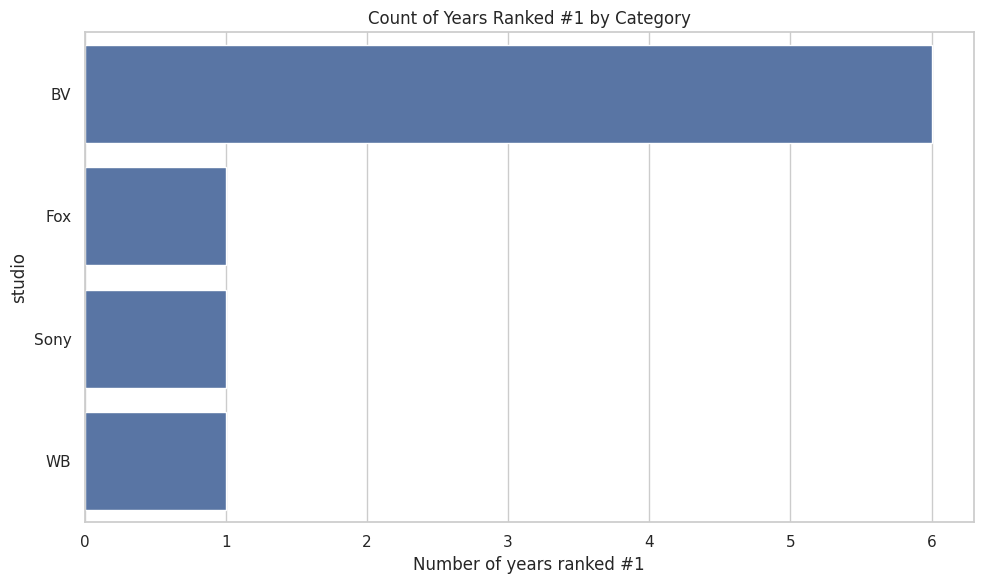

In [14]:
# 6.1 Bar plot: number of years ranked #1 (top 15 categories)
plt.figure(figsize=(10, 6))
plot_df = top1_counts.head(15).copy()
sns.barplot(data=plot_df, x="years_ranked_1", y=category_col)
plt.title("Count of Years Ranked #1 by Category")
plt.xlabel("Number of years ranked #1")
plt.ylabel(category_col)
plt.tight_layout()
plt.show()


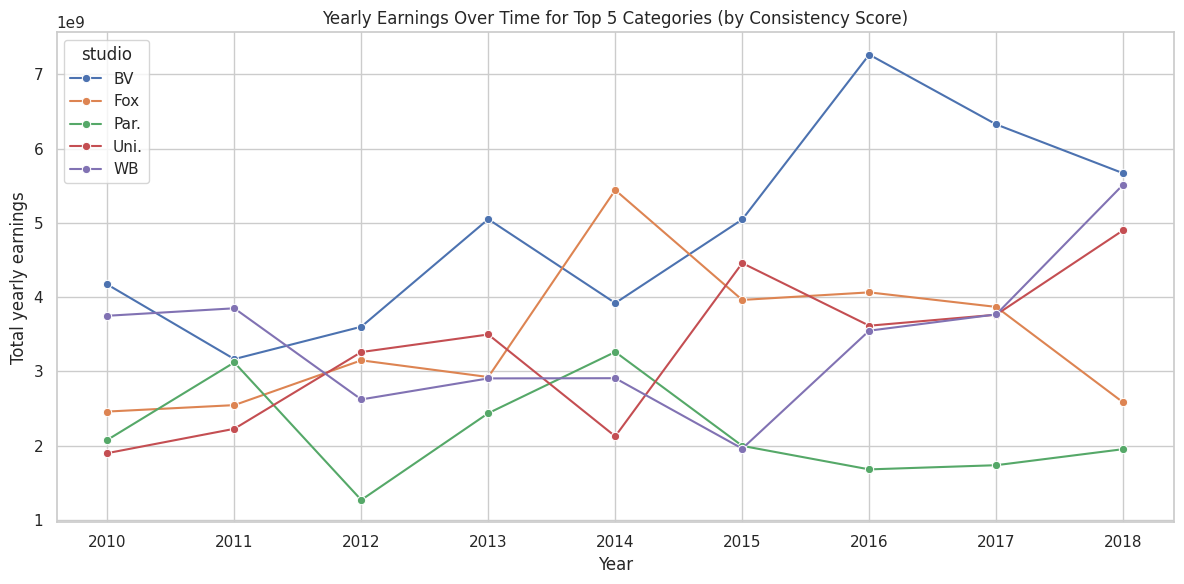

In [15]:
# 6.2 Line plot: yearly earnings for the top categories by consistency score
top_k = 5
top_categories = score_df_sorted[category_col].head(top_k).tolist()

line_df = yearly_totals[yearly_totals[category_col].isin(top_categories)].copy()
line_df = line_df.sort_values([year_col])

plt.figure(figsize=(12, 6))
sns.lineplot(data=line_df, x=year_col, y="yearly_earnings", hue=category_col, marker="o")
plt.title(f"Yearly Earnings Over Time for Top {top_k} Categories (by Consistency Score)")
plt.xlabel("Year")
plt.ylabel("Total yearly earnings")
plt.tight_layout()
plt.show()


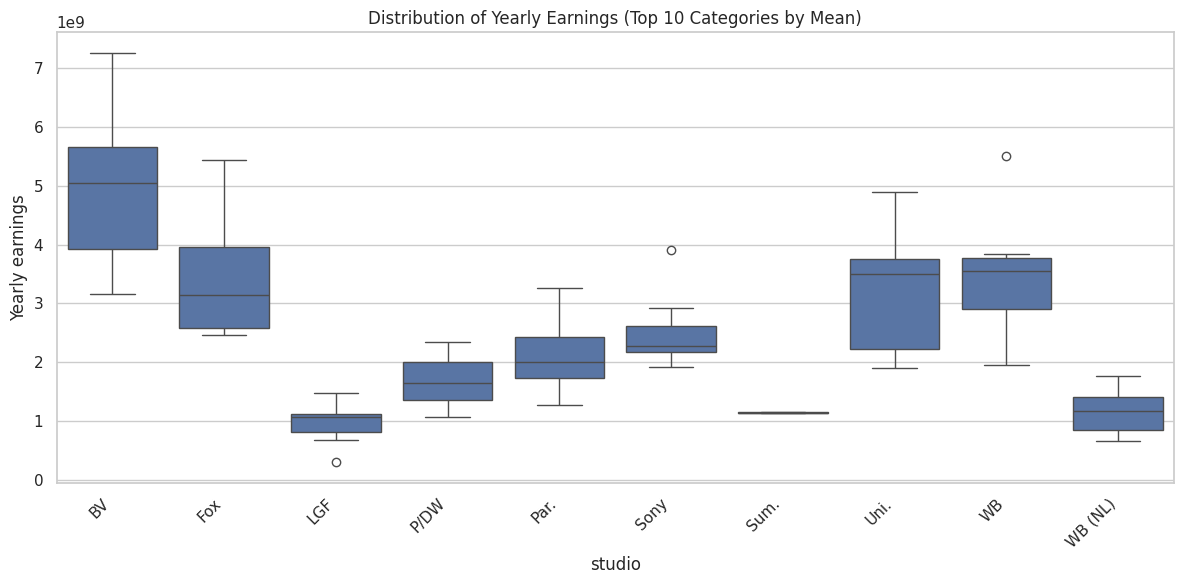

In [9]:
# 6.3 Optional: Boxplot of yearly earnings distribution by category (top 10 by mean earnings)
top10_mean = stats.sort_values("mean", ascending=False)[category_col].head(10).tolist()
box_df = yearly_totals[yearly_totals[category_col].isin(top10_mean)].copy()

plt.figure(figsize=(12, 6))
sns.boxplot(data=box_df, x=category_col, y="yearly_earnings")
plt.title("Distribution of Yearly Earnings (Top 10 Categories by Mean)")
plt.xlabel(category_col)
plt.ylabel("Yearly earnings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 7. Summary & Recommendations

### What this notebook tells you
- It identifies the categories that most often sit at the top each year (rank #1 or top 3).
- It measures stability using standard deviation and coefficient of variation (CV).
- It combines these into a transparent “consistency score” for the studio stakeholders.




### Actionable business recommendations (once genres are available)
1. **Go-ahead strategy:** prioritize the genre(s) with the highest “years in top 3” *and* strong average earnings (not just all-time totals).
2. **Portfolio approach:** if one genre dominates but is volatile (high CV), balance slate allocation with the next-best stable genre.
3. **Risk controls:** treat “spiky” genres as *event bets* (few big wins), and stable genres as *base-load revenue*.
4. **International focus:** if `foreign_gross` is available, segment the same analysis into domestic vs foreign earnings to see which genres travel best.
